# Predicting TCR–Neoantigen Binding with ML models (Isolation Forest and XGBoost)

#### Import Libraries

In [1]:
import os
import scanpy as sc
import scipy.io
import scipy.sparse as sp
import pandas as pd 
import numpy as np
import anndata
import matplotlib.pyplot as plt
import seaborn as sns


#### Set directory variables for the samples

In [2]:
def set_directories(patient_id, base_dir):
    """
    Generate a dictionary containing paths to relevant directories for a given patient.
    
    Parameters:
    - patient_id (str): The unique identifier for the patient.
    - base_dir (str): The base directory containing all patient data.
    
    Returns:
    - dict: A dictionary with paths to gene expression, dextramer, TCR, and CITE-seq data.
    """
    return {
        "dir_gex": os.path.join(base_dir, f"{patient_id}/CellRangerGex_results"),
        "dir_dex": os.path.join(base_dir, f"{patient_id}_dextramer_count/umi_count"),
        "dir_TCR": os.path.join(base_dir, f"{patient_id}_TCR_VDJ/CellRangerVdj_results"),
        "dir_CITE": os.path.join(base_dir, f"{patient_id}_hash_count/umi_count")
    }

# Define base directory and patient IDs
base_dir = "/Users/ecrosse/Desktop/"

# Set directories for each patient
dirs_SRSF2_9 = set_directories("data_for_edie_third_batch_january/WJK-2859_SRSF2_9", base_dir)
dirs_SRSF2_10 = set_directories("dextramer_data_for_edie_january_part_2/WJK-2864_SRSF2_10", base_dir)

# Print to verify the directory structure
print(dirs_SRSF2_9)
print(dirs_SRSF2_10)


{'dir_gex': '/Users/ecrosse/Desktop/data_for_edie_third_batch_january/WJK-2859_SRSF2_9/CellRangerGex_results', 'dir_dex': '/Users/ecrosse/Desktop/data_for_edie_third_batch_january/WJK-2859_SRSF2_9_dextramer_count/umi_count', 'dir_TCR': '/Users/ecrosse/Desktop/data_for_edie_third_batch_january/WJK-2859_SRSF2_9_TCR_VDJ/CellRangerVdj_results', 'dir_CITE': '/Users/ecrosse/Desktop/data_for_edie_third_batch_january/WJK-2859_SRSF2_9_hash_count/umi_count'}
{'dir_gex': '/Users/ecrosse/Desktop/dextramer_data_for_edie_january_part_2/WJK-2864_SRSF2_10/CellRangerGex_results', 'dir_dex': '/Users/ecrosse/Desktop/dextramer_data_for_edie_january_part_2/WJK-2864_SRSF2_10_dextramer_count/umi_count', 'dir_TCR': '/Users/ecrosse/Desktop/dextramer_data_for_edie_january_part_2/WJK-2864_SRSF2_10_TCR_VDJ/CellRangerVdj_results', 'dir_CITE': '/Users/ecrosse/Desktop/dextramer_data_for_edie_january_part_2/WJK-2864_SRSF2_10_hash_count/umi_count'}


## Prepare adata with integrated gene expression, dextramer, CITE-Seq and TCR sequence data
Load gene expression into adata

In [3]:
# Define paths
dir_gex = dirs_SRSF2_9["dir_gex"]
dir_dex = dirs_SRSF2_9["dir_dex"]
dir_CITE = dirs_SRSF2_9["dir_CITE"]

print(dir_gex)
print(dir_dex)
print(dir_CITE)

adata = sc.read_10x_h5(os.path.join(dir_gex, "filtered_feature_bc_matrix.h5"))
adata.var_names_make_unique()
adata

/Users/ecrosse/Desktop/data_for_edie_third_batch_january/WJK-2859_SRSF2_9/CellRangerGex_results
/Users/ecrosse/Desktop/data_for_edie_third_batch_january/WJK-2859_SRSF2_9_dextramer_count/umi_count
/Users/ecrosse/Desktop/data_for_edie_third_batch_january/WJK-2859_SRSF2_9_hash_count/umi_count


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1900: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1900: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 8008 × 36601
    var: 'gene_ids', 'feature_types', 'genome'

Load CITE and Dextramer data

In [4]:
# Load CITE-seq data
cite_matrix = scipy.io.mmread(f"{dir_CITE}/matrix.mtx.gz").T.tocsr()
cite_barcodes = pd.read_csv(f"{dir_CITE}/barcodes.tsv.gz", header=None, sep='\t')[0].values + "-1"
cite_features = pd.read_csv(f"{dir_CITE}/features.tsv.gz", header=None, sep='\t')[1].values

# Load Dextramer data
dex_matrix = scipy.io.mmread(f"{dir_dex}/matrix.mtx.gz").T.tocsr()
dex_barcodes = pd.read_csv(f"{dir_dex}/barcodes.tsv.gz", header=None, sep='\t')[0].values + "-1"
dex_features = pd.read_csv(f"{dir_dex}/features.tsv.gz", header=None, sep='\t')[1].values

# Find common barcodes across all datasets
common_barcodes = list(set(adata.obs_names) & set(cite_barcodes) & set(dex_barcodes))

# Subset adata to common barcodes
adata = adata[adata.obs_names.isin(common_barcodes)].copy()

# Ensure barcodes are in the same order
cite_indices = np.array([np.where(cite_barcodes == bc)[0][0] for bc in adata.obs_names])
dex_indices = np.array([np.where(dex_barcodes == bc)[0][0] for bc in adata.obs_names])

cite_matrix = cite_matrix[cite_indices, :]
dex_matrix = dex_matrix[dex_indices, :]

# Store multimodal data in .obsm
adata.obsm["CITE"] = cite_matrix
adata.obsm["Dextramer"] = dex_matrix

# Store feature names in .uns
adata.uns["CITE_features"] = cite_features
adata.uns["Dextramer_features"] = dex_features

print("CITE-seq and Dextramer data successfully added to anndata.")



CITE-seq and Dextramer data successfully added to anndata.


Write raw adata

In [5]:
adata.write("adata_raw.h5ad")

QC steps

In [6]:
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata.var["mt"] = adata.var_names.str.startswith("MT-")

sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)

In [7]:
print(adata.obs.describe())

       n_genes_by_counts  total_counts  total_counts_mt  pct_counts_mt
count        7992.000000   7992.000000      7992.000000    7992.000000
mean         1840.969094   4664.024902        42.327953       1.058015
std           688.167250   2522.644531        40.968998       1.335171
min            40.000000    500.000000         0.000000       0.000000
25%          1481.000000   3430.000000        11.000000       0.309042
50%          1794.000000   4375.000000        36.000000       0.857646
75%          2104.250000   5321.250000        61.000000       1.360179
max          6367.000000  30498.000000       752.000000      27.407408


In [8]:
sc.pp.filter_cells(adata, min_genes=250)
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.filter_cells(adata, min_counts=500)
# Saving count data
adata.layers["counts"] = adata.X.copy()

# Normalize data (log1p normalization)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

sc.pp.highly_variable_genes(adata, n_top_genes=4000)

# Filter out genes starting with "TR"
variable_genes = adata.var["highly_variable"]
filtered_variable_genes = adata.var_names[variable_genes & ~adata.var_names.str.startswith("TR")]
# Update the list of highly variable genes
adata.var["highly_variable"] = adata.var_names.isin(filtered_variable_genes)

# Scale the data
sc.pp.scale(adata, max_value=10)  # Scale all genes

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:215: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']


VDJ sequence / clonotype info integration into adata

In [9]:
# set TCR dir
dir_TCR = dirs_SRSF2_9["dir_TCR"]


# Load V(D)J data
vdj = pd.read_csv(f"{dir_TCR}/filtered_contig_annotations.csv")

# Filtering steps
tcr = vdj[
    (vdj["high_confidence"] == True) & 
    (vdj["chain"].isin(["TRA", "TRB"])) & 
    (vdj["productive"] == True) & 
    (vdj["umis"] >= 3)
][["barcode", "chain", "raw_clonotype_id", 
   "v_gene", "d_gene", "j_gene", "c_gene", 
   "cdr1_nt", "cdr2_nt", "cdr3_nt"]]

# Group by raw_clonotype_id and filter for entries that contain both TRA and TRB chains
tcr = tcr.groupby("raw_clonotype_id").filter(lambda g: any(g["chain"] == "TRA") and any(g["chain"] == "TRB"))

# Reset index if needed
tcr = tcr.reset_index(drop=True)

# Print summary
print(tcr.head())

# Load clonotype data
clono = pd.read_csv(f"{dir_TCR}/clonotypes.csv")

# Select and rename columns
clono = clono[["clonotype_id", "cdr3s_aa", "cdr3s_nt"]].rename(columns={"clonotype_id": "raw_clonotype_id"})

# Perform a left join with tcr on "raw_clonotype_id"
tcr = tcr.merge(clono, on="raw_clonotype_id", how="left")

# Select barcode and raw_clonotype_id
clonotype_info = tcr[["barcode", "raw_clonotype_id"]].drop_duplicates(subset=["barcode"])

# Set barcode as row index and drop barcode column
clonotype_info = clonotype_info.set_index("barcode")

# Print the resulting dataframe
print(clonotype_info.head())

# Add tcr to metadata
adata.obs = adata.obs.join(clonotype_info, how="left")

# Check if the metadata was added
print(adata.obs.head())

              barcode chain raw_clonotype_id    v_gene d_gene   j_gene c_gene  \
0  AAACCTGAGCCAGTAG-1   TRA     clonotype332   TRAV1-2    NaN   TRAJ12   TRAC   
1  AAACCTGAGCCAGTAG-1   TRB     clonotype332   TRBV6-1  TRBD2  TRBJ2-1  TRBC2   
2  AAACCTGAGGAGTTGC-1   TRA    clonotype1183  TRAV26-2    NaN   TRAJ49   TRAC   
3  AAACCTGAGGAGTTGC-1   TRB    clonotype1183    TRBV19  TRBD1  TRBJ2-7  TRBC2   
4  AAACCTGAGTACGACG-1   TRB       clonotype5    TRBV28    NaN  TRBJ1-1  TRBC1   

                 cdr1_nt             cdr2_nt  \
0     ACATCTGGGTTCAACGGG  AATGTTCTGGATGGTTTG   
1        ATGAACCATAACTCC  TCAGCTTCTGAGGGTACC   
2  ACAATCAGTGGAACTGATTAC     GGTCTTACAAGCAAT   
3        TTGAACCACGATGCC  TCACAGATAGTAAATGAC   
4        ATGGACCATGAAAAT  TCATATGATGTTAAAATG   

                                         cdr3_nt  
0           TGTGCTGGGATGGATAGCAGCTATAAATTGATCTTC  
1  TGTGCCAGCAGTGAACTAGCGGGAGGGTACAATGAGCAGTTCTTC  
2           TGCATCCTGAGAGACTCGGATAACCAGTTCTATTTT  
3  TGTGCCAGTAGCGACAC

CITE-Seq Dex+ cell determination - CITE-Seq hashing antibody represents Dextramer - population

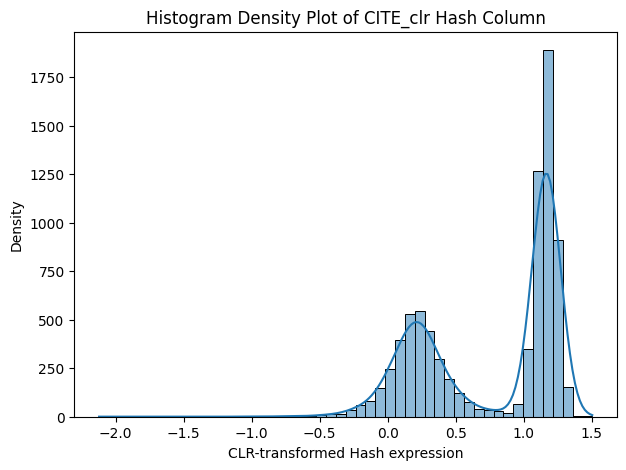

In [10]:
def clr_transform(matrix, eps=1e-9):
    """Applies CLR transformation to an input matrix (cell-wise), optimized for sparse matrices."""
    if sp.issparse(matrix):
        matrix = matrix.toarray()  # Convert sparse matrix to dense (if memory allows)
    
    gm = np.exp(np.mean(np.log(matrix + eps), axis=1, keepdims=True))  # Geometric mean per cell
    return np.log((matrix + eps) / (gm + eps))  # Standard CLR transformation

# Apply CLR to CITE-seq data
adata.obsm["CITE_clr"] = clr_transform(adata.obsm["CITE"])


# Identify the index of the "Hash" column
hash_col_index = np.where(adata.uns["CITE_features"] == "Hash")[0][0]

# Extract the Hash column
hash_values = adata.obsm["CITE_clr"][:, hash_col_index]

# Plot density histogram
plt.figure(figsize=(7, 5))
sns.histplot(hash_values, kde=True, bins=50)

plt.xlabel("CLR-transformed Hash expression")
plt.ylabel("Density")
plt.title("Histogram Density Plot of CITE_clr Hash Column")
plt.show()

Using the generated plot manually set the threshold cut off hashed counts (more reliable to do it manually)

In [11]:
# Extract the Hash column from CITE_clr
hash_counts = adata.obsm["CITE_clr"][:, hash_col_index]

# Store the extracted counts in adata.obs
adata.obs["HashCounts"] = hash_counts
# Create 'manual_hash_dmux' based on HashCounts threshold
adata.obs["manual_hash_dmux"] = np.where(adata.obs["HashCounts"] > 0.8, "CITE_hash", "Negative")
adata.obs["manual_hash_dmux"].value_counts()


manual_hash_dmux
CITE_hash    4680
Negative     3311
Name: count, dtype: int64

Remove unmapped dextramer features from dex expression matrix

In [12]:
# Identify index of "Unmapped"
unmapped_idx = np.where(adata.uns["Dextramer_features"] == "unmapped")[0][0]

# Remove "Unmapped" from feature list
adata.uns["Dextramer_features"] = np.delete(adata.uns["Dextramer_features"], unmapped_idx)

# Remove "Unmapped" from the Dextramer matrix
adata.obsm["Dextramer"] = sp.csr_matrix(np.delete(adata.obsm["Dextramer"].toarray(), unmapped_idx, axis=1))

# Sum total dextramer counts per cell and store in .obs
adata.obs["Dextramer_total_counts"] = adata.obsm["Dextramer"].sum(axis=1)

# Verify the new column
print(adata.obs["Dextramer_total_counts"].head())


AAACCTGAGAGACTAT-1    10
AAACCTGAGCCAGTAG-1    22
AAACCTGAGGAGTTGC-1    18
AAACCTGAGTACGACG-1    34
AAACCTGCACAGTCGC-1    13
Name: Dextramer_total_counts, dtype: int64


Check that Dextramer read counts are higher in Dex+ population afer CITE hashing dmux

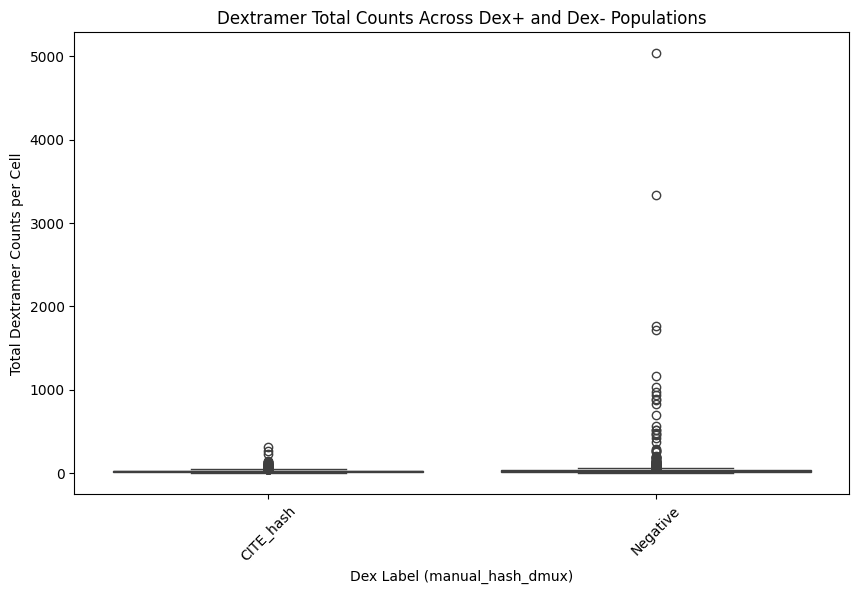

In [13]:
# Create a boxplot of Dextramer total counts grouped by manual_hash_dmux categories
plt.figure(figsize=(10, 6))
sns.boxplot(data=adata.obs, x="manual_hash_dmux", y="Dextramer_total_counts")

# Customize plot labels and title
plt.xlabel("Dex Label (manual_hash_dmux)")
plt.ylabel("Total Dextramer Counts per Cell")
plt.title("Dextramer Total Counts Across Dex+ and Dex- Populations")

# Rotate x-axis labels if necessary for readability
plt.xticks(rotation=45)

plt.show()


Check out distribution of reads across dextramers to identify outliers e.g. SRSF2-18

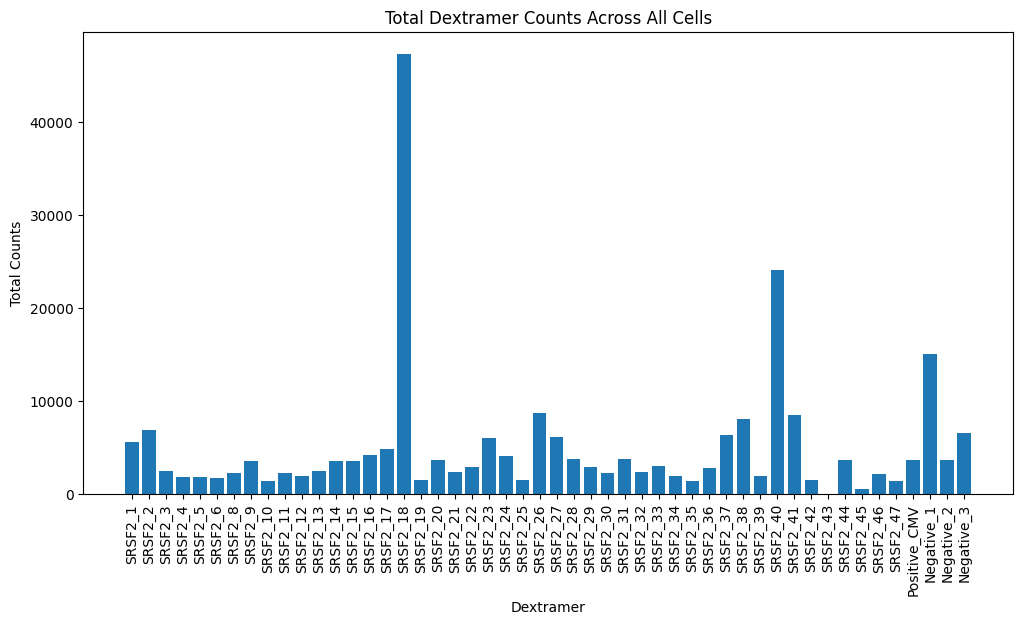

In [14]:
# Sum counts per dextramer across all cells
dextramer_counts = np.array(adata.obsm["Dextramer"].sum(axis=0)).flatten()

# Plot
plt.figure(figsize=(12, 6))
plt.bar(adata.uns["Dextramer_features"], dextramer_counts)
plt.xticks(rotation=90)
plt.xlabel("Dextramer")
plt.ylabel("Total Counts")
plt.title("Total Dextramer Counts Across All Cells")
plt.show()

### Feature Engineering - Start Building the Feature Set for ML Pipelines

Different features, once calculated, will be stored in adata

##### 1. Normalized dextramer signal (Dextramer_norm)

Find the fold change for each cell of the dextramer signal compared to the mean in the Dex-

In [15]:
# Extract dextramer matrix as dense array
dex_matrix = adata.obsm["Dextramer"].toarray()

# Extract Dex+ and Dex- labels
dex_labels = adata.obs["manual_hash_dmux"]

# Identify Dex- cells 
dex_neg_cells = dex_labels == "CITE_hash"  

# Compute the mean background signal for each dextramer using only Dex- cells
dex_background = dex_matrix[dex_neg_cells].mean(axis=0)  

# Normalize dextramer signals by their background (Fold-Change Enrichment)
dex_fold_change = dex_matrix / dex_background

# Apply log transformation to reduce extreme values 
dex_log_fc = np.log1p(dex_fold_change)  # log(1 + x) transformation

# Store the background-normalized dextramer signals back in adata
adata.obsm["Dextramer_norm"] = dex_log_fc

# Print sanity check
print("Shape of normalized dextramer matrix:", adata.obsm["Dextramer_norm"].shape)
print("First few values of a random dextramer after normalization:\n", dex_log_fc[:, 0][:5])

Shape of normalized dextramer matrix: (7991, 50)
First few values of a random dextramer after normalization:
 [0. 0. 0. 0. 0.]


Plot some normalized dextramers

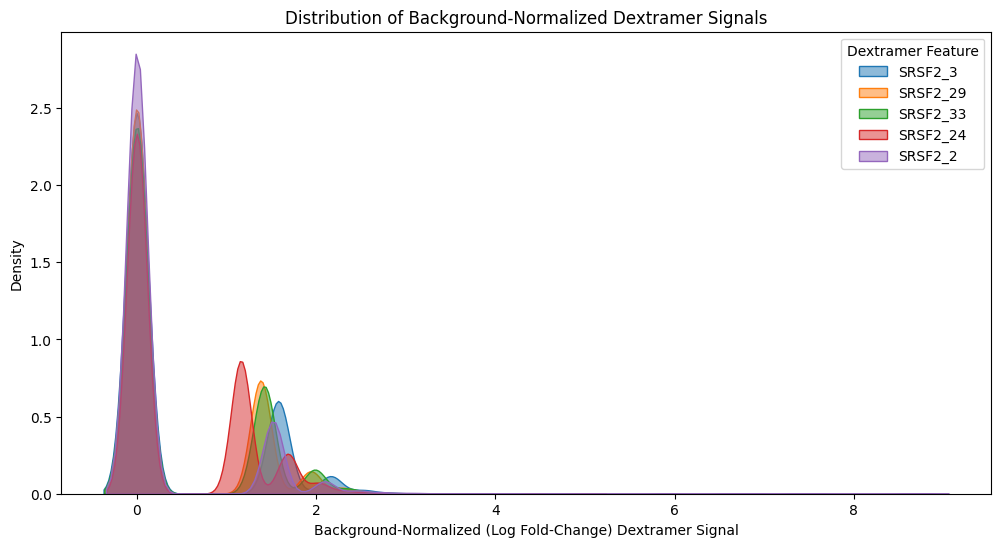

In [16]:
# Select a few dextramers to visualize (randomly choosing 5 for now)
num_features = adata.obsm["Dextramer_norm"].shape[1]
selected_dextramers = np.random.choice(num_features, size=5, replace=False)

# Convert the selected dextramers into a DataFrame for easier plotting
dex_norm_df = pd.DataFrame(adata.obsm["Dextramer_norm"][:, selected_dextramers],
                           columns=[adata.uns["Dextramer_features"][i] for i in selected_dextramers])

# Plot the density distribution of the selected dextramer signals
plt.figure(figsize=(12, 6))
for col in dex_norm_df.columns:
    sns.kdeplot(dex_norm_df[col], label=col, fill=True, alpha=0.5)

plt.xlabel("Background-Normalized (Log Fold-Change) Dextramer Signal")
plt.ylabel("Density")
plt.title("Distribution of Background-Normalized Dextramer Signals")
plt.legend(title="Dextramer Feature")
plt.show()

##### 2. Relative enrichment score (Dextramer_enrichment)

Relative enrichment score of a dextramer per cell compared to the mean of the Dex+ population.

In [17]:
# Identify Dex+ cells
dex_pos_cells = dex_labels != "CITE_hash" 

# Compute mean dextramer signal across Dex+ cells (per dextramer)
dex_mean_pos = dex_matrix[dex_pos_cells].mean(axis=0)  # Mean per dextramer in Dex+ cells

# Compute relative enrichment: deviation from Dex+ mean (per dextramer, per cell)
dex_enrichment = dex_matrix - dex_mean_pos  # Element-wise subtraction

# Store in adata
adata.obsm["Dextramer_enrichment"] = dex_enrichment

# Print sanity check
print("Shape of Dex+ enrichment matrix:", adata.obsm["Dextramer_enrichment"].shape)
print("First few values of a random dextramer after enrichment calculation:\n", dex_enrichment[:, 0][:5])

Shape of Dex+ enrichment matrix: (7991, 50)
First few values of a random dextramer after enrichment calculation:
 [-1.34340079 -1.34340079 -1.34340079 -1.34340079 -1.34340079]


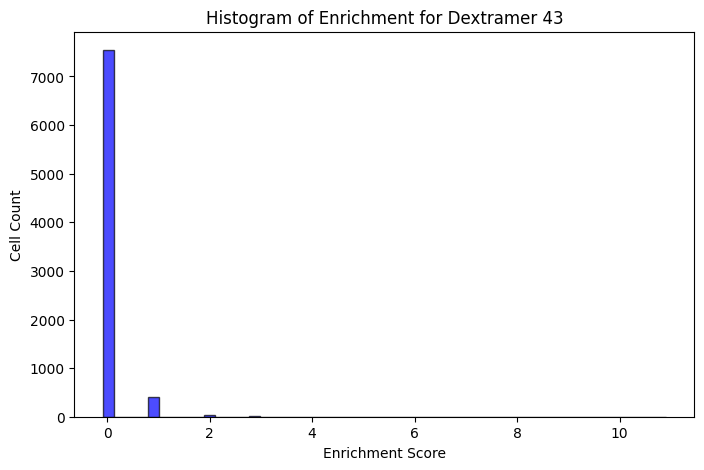

In [18]:
# Select a dextramer
dex_idx = 43  # Change this to visualize a different dextramer
dex_values = adata.obsm["Dextramer_enrichment"][:, dex_idx]

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(dex_values, bins=50, alpha=0.7, color='b', edgecolor='k')
plt.xlabel("Enrichment Score")
plt.ylabel("Cell Count")
plt.title(f"Histogram of Enrichment for Dextramer {dex_idx}")
plt.show()

##### 3. Dex+ population enriched clonotypes (clonotype_enrichment)

Identify enriched clonotypes within Dex+ cells

In [19]:
# Extract TCR clonotype IDs and Dex+/- labels
clonotypes = adata.obs["raw_clonotype_id"]
dex_labels = adata.obs["manual_hash_dmux"]

# Identify Dex+ and Dex- cells based on corrected labels
dex_pos_mask = dex_labels == "Negative"  # Dex+ group
dex_neg_mask = dex_labels == "CITE_hash"  # Dex- group

# Compute total number of cells in each group
total_dex_pos = np.sum(dex_pos_mask)
total_dex_neg = np.sum(dex_neg_mask)

# Count occurrences of each clonotype in Dex+ and Dex- cells
clonotype_counts = pd.DataFrame({
    "Dex+ Count": clonotypes[dex_pos_mask].value_counts(),
    "Dex- Count": clonotypes[dex_neg_mask].value_counts()
}).fillna(0)


# Compute frequency (proportion) in each group
clonotype_counts["Dex+ Frequency"] = clonotype_counts["Dex+ Count"] / total_dex_pos
clonotype_counts["Dex- Frequency"] = clonotype_counts["Dex- Count"] / total_dex_neg

# Compute fold-change enrichment (log-scaled for better interpretability)
clonotype_counts["Enrichment Ratio"] = clonotype_counts["Dex+ Frequency"] / (clonotype_counts["Dex- Frequency"] + 1e-6)
clonotype_counts["Log Enrichment"] = np.log2(clonotype_counts["Enrichment Ratio"] + 1e-6)


# Store results in adata for later use
adata.uns["clonotype_enrichment"] = clonotype_counts

# Print top TCR clonotypes with highest enrichment
print("Top 10 TCR clonotypes enriched in Dex+ cells:")
print(clonotype_counts.sort_values(by="Dex+ Frequency", ascending=False).head(10))


Top 10 TCR clonotypes enriched in Dex+ cells:
                  Dex+ Count  Dex- Count  Dex+ Frequency  Dex- Frequency  \
raw_clonotype_id                                                           
clonotype1             137.0       369.0        0.041377        0.078846   
clonotype5             100.0       106.0        0.030202        0.022650   
clonotype2             100.0       198.0        0.030202        0.042308   
clonotype6              98.0        88.0        0.029598        0.018803   
clonotype3              77.0       182.0        0.023256        0.038889   
clonotype7              63.0        95.0        0.019027        0.020299   
clonotype16             56.0         1.0        0.016913        0.000214   
clonotype17             39.0        12.0        0.011779        0.002564   
clonotype8              32.0        79.0        0.009665        0.016880   
clonotype12             31.0        36.0        0.009363        0.007692   

                  Enrichment Ratio  Log E

##### 4. Dextramer rank per cell. 5. Dextramer competition per cell

Dextramer rankings and Dextramer competition score (ie. the margin between top dextramers per cell)

In [20]:
# Use normalized dextramer data
dex_matrix_norm = adata.obsm["Dextramer_norm"]

# Compute ranks within each cell
dextramer_ranks = np.argsort(-dex_matrix_norm, axis=1)  # Descending order
dextramer_rank_values = np.argsort(dextramer_ranks, axis=1) + 1  # Convert to rank (1 = highest)

# Compute competition score
sorted_dex_values = np.sort(dex_matrix_norm, axis=1)[:, ::-1]  # Sort values descending
top_dextramer_signal = sorted_dex_values[:, 0]  # Strongest dextramer per cell
second_strongest_signal = sorted_dex_values[:, 1]  # Second strongest dextramer per cell

top_dextramer_margin = (top_dextramer_signal - second_strongest_signal) / (top_dextramer_signal + 1e-6)

# Store in adata for ML use later
adata.obsm["Dextramer_rank"] = dextramer_rank_values  # Rank matrix per cell/dextramer
adata.obs["Top_dextramer_margin"] = top_dextramer_margin  # One value per cell


##### Build the Feature Matrix `X`

This section extracts and compiles all engineered features from the `AnnData` object (`adata`) into a unified DataFrame called `X`. This matrix serves as the input for the machine learning pipelines (XGBoost and Isolation Forest). Each row represents a `(cell, dextramer)` pair with features describing signal strength, clonotype context, and enrichment characteristics.

First get dextramer features:

In [21]:
# Extract Cell-Level Features from `obs`
cell_features = adata.obs[["raw_clonotype_id", "Top_dextramer_margin"]].copy()

# Compute clonotype count as an additional feature
clonotype_counts = adata.obs["raw_clonotype_id"].value_counts().to_dict()
cell_features["clonotype_count"] = cell_features["raw_clonotype_id"].map(clonotype_counts)  

# Extract Dextramer-Level Features from `obsm`
dex_norm_df = pd.DataFrame(adata.obsm["Dextramer_norm"], index=adata.obs_names)
dex_rank_df = pd.DataFrame(adata.obsm["Dextramer_rank"], index=adata.obs_names)
dex_enrich_df = pd.DataFrame(adata.obsm["Dextramer_enrichment"], index=adata.obs_names)  

# Melt the data to create a (cell, dextramer) pair structure
dex_norm_melted = dex_norm_df.reset_index().melt(id_vars="index", var_name="dextramer", value_name="dex_norm")
dex_rank_melted = dex_rank_df.reset_index().melt(id_vars="index", var_name="dextramer", value_name="dex_rank")
dex_enrich_melted = dex_enrich_df.reset_index().melt(id_vars="index", var_name="dextramer", value_name="dex_enrich")  

# Merge all dextramer-related features
dex_features = dex_norm_melted.merge(dex_rank_melted, on=["index", "dextramer"]).merge(dex_enrich_melted, on=["index", "dextramer"])  

# Merge with Cell-Level Features (now includes clonotype count)
X = pd.merge(dex_features, cell_features, left_on="index", right_index=True)

# Rename index for clarity
X.rename(columns={"index": "cell_id"}, inplace=True)


Matrix tidying

In [22]:
# Fill missing clonotype IDs with "Unknown"
X["raw_clonotype_id"] = X["raw_clonotype_id"].fillna("_no_clonotype_")

# Fill missing clonotype counts with 0
X["clonotype_count"] = X["clonotype_count"].fillna(0)

# Rename dextramer indices with their feature names
dextramer_names = list(adata.uns["Dextramer_features"])  

# Create mapping from index to name
dex_index_to_name = {i: name for i, name in enumerate(dextramer_names)}

# Print a few mappings to verify
print("Example dextramer mapping:", list(dex_index_to_name.items())[:10])

# Apply mapping
X["dextramer"] = X["dextramer"].map(dex_index_to_name)

Example dextramer mapping: [(0, 'SRSF2_1'), (1, 'SRSF2_2'), (2, 'SRSF2_3'), (3, 'SRSF2_4'), (4, 'SRSF2_5'), (5, 'SRSF2_6'), (6, 'SRSF2_8'), (7, 'SRSF2_9'), (8, 'SRSF2_10'), (9, 'SRSF2_11')]


Add clonotype enrichment to X

In [23]:
# Convert stored enrichment DataFrame from adata.uns
clono_enrich_df = adata.uns["clonotype_enrichment"]

# Just keep the 'Log Enrichment' column 
clono_enrich_df = clono_enrich_df[["Log Enrichment"]]

# Merge into your X DataFrame by raw_clonotype_id
X = X.merge(clono_enrich_df, left_on="raw_clonotype_id", right_index=True, how="left")

# Rename for consistency
X.rename(columns={"Log Enrichment": "clonotype_enrichment"}, inplace=True)

# Fill missing enrichment values with 0
X["clonotype_enrichment"] = X["clonotype_enrichment"].fillna(0)

# Sanity check
print(X[["raw_clonotype_id", "clonotype_enrichment"]].head())

      raw_clonotype_id  clonotype_enrichment
0       _no_clonotype_                   0.0
7991    _no_clonotype_                   0.0
15982   _no_clonotype_                   0.0
23973   _no_clonotype_                   0.0
31964   _no_clonotype_                   0.0


Check X is looking as expected

In [24]:
X

,cell_id,dextramer,dex_norm,dex_rank,dex_enrich,raw_clonotype_id,Top_dextramer_margin,clonotype_count,clonotype_enrichment
0,AAACCTGAGAGACTAT-1,SRSF2_1,0.000000,15,-1.343401,_no_clonotype_,0.029817,0.0,0.000000
7991,AAACCTGAGAGACTAT-1,SRSF2_2,0.000000,29,-1.691634,_no_clonotype_,0.029817,0.0,0.000000
15982,AAACCTGAGAGACTAT-1,SRSF2_3,0.000000,30,-0.380248,_no_clonotype_,0.029817,0.0,0.000000
23973,AAACCTGAGAGACTAT-1,SRSF2_4,0.000000,31,-0.294171,_no_clonotype_,0.029817,0.0,0.000000
31964,AAACCTGAGAGACTAT-1,SRSF2_5,0.000000,32,-0.288432,_no_clonotype_,0.029817,0.0,0.000000
...,...,...,...,...,...,...,...,...,...
367585,TTTGTCATCATAAAGG-1,SRSF2_47,0.000000,20,-0.257928,clonotype3,0.231058,259.0,-0.741801
375576,TTTGTCATCATAAAGG-1,Positive_CMV,0.000000,15,-0.514648,clonotype3,0.231058,259.0,-0.741801
383567,TTTGTCATCATAAAGG-1,Negative_1,0.000000,11,-2.037451,clonotype3,0.231058,259.0,-0.741801
391558,TTTGTCATCATAAAGG-1,Negative_2,0.000000,27,-0.548475,clonotype3,0.231058,259.0,-0.741801


(Code to incorporate partial ground truth - for Random Forests only so obsolete)

In [ ]:
# # Manually define the known true binder
# known_true_pairs = [("clonotype16", "SRSF2_31")]

# # Initialize y as all zeros (assume non-binder by default)
# y = pd.Series(0, index=X.index)

# # Set y = 1 for known true binders
# y.loc[X[["raw_clonotype_id", "dextramer"]].apply(tuple, axis=1).isin(known_true_pairs)] = 1

# print("Label distribution:\n", y.value_counts())


In [ ]:
# from sklearn.model_selection import train_test_split
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import accuracy_score, classification_report

# # Define features (excluding non-numeric columns)
# feature_cols = [
#     "dex_norm",
#     "dex_rank",
#     "dex_enrich",
#     "Top_dextramer_margin",
#     "clonotype_count",
#     "clonotype_enrichment"  # <- new feature!
# ]

# X_model = X[feature_cols]  # Feature matrix
# y_model = y  # Target variable

# # Split into training (80%) and test (20%)
# X_train, X_test, y_train, y_test = train_test_split(X_model, y_model, test_size=0.2, random_state=42, stratify=y)

# # Train Random Forest
# rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")
# rf_model.fit(X_train, y_train)

# # Predict on test set
# y_pred = rf_model.predict(X_test)

# # Evaluate performance
# accuracy = accuracy_score(y_test, y_pred)
# report = classification_report(y_test, y_pred)

# print(f"Model Accuracy: {accuracy:.4f}")
# print("Classification Report:\n", report)


In [ ]:
# print(X.columns)  # Look for 'clonotype_enrichment'
# print(X["clonotype_enrichment"].describe())  # Sanity check values


#### ML model 1 - Isolation forest model

This works well if there are expected to be very few true binders (which is what we found with our data). It requires no supervision and detects 'anomalies' in the patterns which are actually expected to be true binders.

First we scale the matrix

In [58]:
from sklearn.preprocessing import StandardScaler

# Select the same feature columns you're using in XGBoost
feature_cols = ["dex_norm", 
                #"dex_rank", 
                "dex_enrich", 
                #"Top_dextramer_margin", 
                "clonotype_count", 
                "clonotype_enrichment"]
X_model = X[feature_cols]

# Scale the feature matrix for Isolation Forest
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_model)


Then we fit the model

In [59]:
from sklearn.ensemble import IsolationForest

# Define Isolation Forest model
iso_forest = IsolationForest(n_estimators=100, contamination=0.001, random_state=42)  # 0.1% expected outliers

# Fit the model on scaled data
iso_forest.fit(X_scaled)

# Predict anomaly scores (-1 = outlier, 1 = inlier)
X["binding_anomaly_score"] = iso_forest.decision_function(X_scaled)  # Higher = more normal, lower = more anomalous
X["is_likely_binder"] = iso_forest.predict(X_scaled)  # -1 means likely binder, 1 means normal background

print("Isolation Forest model trained ✅")

Isolation Forest model trained ✅


Examine the output by grouping by dextramer / clonotype

In [60]:
# Group by (dextramer, clonotype)
X_grouped = X.groupby(["dextramer", "raw_clonotype_id"]).agg(
    mean_score=("binding_anomaly_score", "mean"),  # Average anomaly score
    min_score=("binding_anomaly_score", "min"),    # Best anomaly score
    count=("binding_anomaly_score", "count")       # How often this pair appears
).reset_index()

# Compute a final ranking score (higher weight for best anomaly score, adjusted by count)
X_grouped["final_score"] = X_grouped["min_score"] * 0.7 + X_grouped["mean_score"] * 0.3

# Rank by final score (lower = better binder)
X_ranked = X_grouped.sort_values(by="final_score")

# Display top predicted unique binding pairs
print("Top predicted unique neoantigen-TCR binding pairs:\n", X_ranked.head(50))


Top predicted unique neoantigen-TCR binding pairs:
           dextramer raw_clonotype_id  mean_score  min_score  count  \
22918      SRSF2_26    clonotype1353   -0.042614  -0.042614      1   
29228      SRSF2_31      clonotype16   -0.004137  -0.053909     57   
44296      SRSF2_44     clonotype950   -0.035410  -0.035410      1   
16257       SRSF2_2     clonotype558   -0.035410  -0.035410      1   
29148      SRSF2_31    clonotype1467   -0.031851  -0.031851      1   
13724      SRSF2_18    clonotype1519   -0.031839  -0.031839      1   
24707      SRSF2_27     clonotype950   -0.031839  -0.031839      1   
37079      SRSF2_38     clonotype950   -0.031839  -0.031839      1   
36048      SRSF2_37     clonotype950   -0.031839  -0.031839      1   
38110      SRSF2_39     clonotype950   -0.029299  -0.029299      1   
16459       SRSF2_2     clonotype950   -0.028285  -0.028285      1   
5303       SRSF2_10    clonotype1249   -0.027791  -0.027791      1   
47389      SRSF2_47     clonotype950  

/var/folders/tr/vn7tq20j5757j67mf5gf2xg80000gp/T/ipykernel_47235/314863011.py:16: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  plt.tight_layout()
/Users/ecrosse/Library/Python/3.10/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


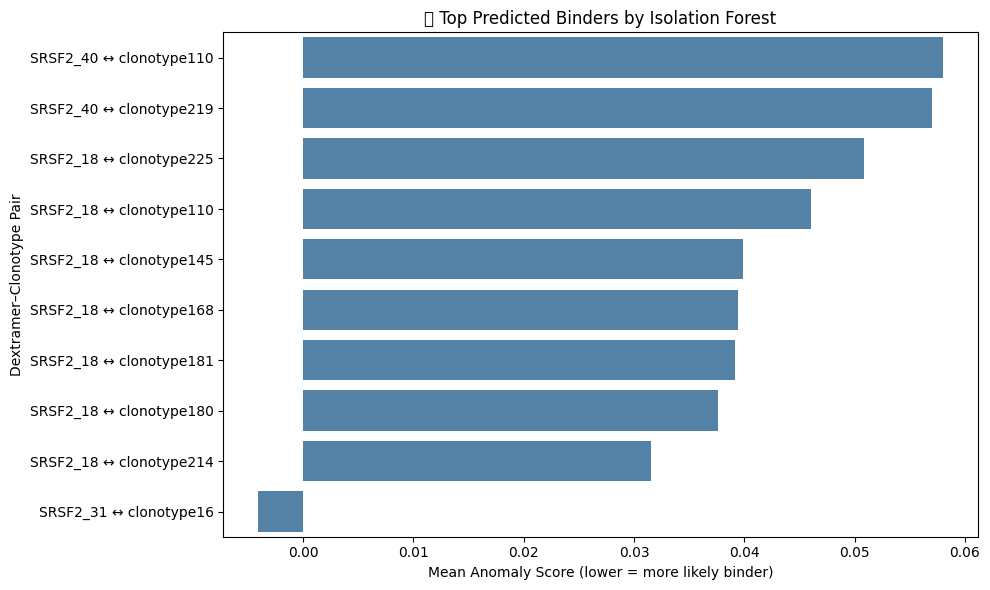

In [61]:
# Filter for clonotypes seen in at least 3 cells (optional)
filtered = X_grouped[X_grouped["count"] >= 3]

# Sort by mean_score (lower = more anomalous = more likely binder)
top_pairs = filtered.sort_values("mean_score").head(10)

# Create a label for plotting
top_pairs["pair"] = top_pairs["dextramer"] + " ↔ " + top_pairs["raw_clonotype_id"]

plt.figure(figsize=(10, 6))
sns.barplot(data=top_pairs, x="mean_score", y="pair", color="steelblue")  # Use a fixed color
plt.xlabel("Mean Anomaly Score (lower = more likely binder)")
plt.ylabel("Dextramer–Clonotype Pair")
plt.title("🔍 Top Predicted Binders by Isolation Forest")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

##### ML model 2 - XGBoost

This requires a partial ground truth for which we use the normalized dextramer count per cell. 

In [50]:
from xgboost import XGBRegressor

# Feature set
feature_cols = [#"dex_rank", #commented out this as its not independent from dex_norm
                "dex_enrich", 
                #"Top_dextramer_margin", 
                "clonotype_count", 
                "clonotype_enrichment"]
X_model = X[feature_cols]

# Target = normalized dextramer signal (assumed indicative of binding strength)
y_model = X["dex_norm"]


In [51]:
# Initialize and train model
xgb_model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    random_state=42
)

xgb_model.fit(X_model, y_model)

print("✅ XGBoost model trained on dex_norm as target")



✅ XGBoost model trained on dex_norm as target


In [52]:
# Predict binding likelihood for all (clonotype, dextramer) pairs
X["binding_score_xgb"] = xgb_model.predict(X_model)



In [53]:
# Aggregate: mean predicted score per (dextramer, clonotype)
X_grouped = X.groupby(["dextramer", "raw_clonotype_id"])["binding_score_xgb"].mean().reset_index()

# Rank: sort by predicted binding score (descending = more likely)
X_ranked = X_grouped.sort_values(by="binding_score_xgb", ascending=False)

# Show top predicted binders
print("🔝 Top predicted neoantigen–TCR binding pairs (by XGBoost on dex_norm):\n")
print(X_ranked.head(50))


🔝 Top predicted neoantigen–TCR binding pairs (by XGBoost on dex_norm):

        dextramer raw_clonotype_id  binding_score_xgb
19552    SRSF2_22     clonotype950           2.974787
37079    SRSF2_38     clonotype950           2.974787
13792    SRSF2_18    clonotype1634           2.974787
456    Negative_1    clonotype1746           2.974787
154    Negative_1    clonotype1255           2.974787
13522    SRSF2_18    clonotype1201           2.974787
39299    SRSF2_40    clonotype1203           2.974787
2025   Negative_2     clonotype950           2.974787
12131    SRSF2_16     clonotype555           2.974787
40207    SRSF2_40     clonotype997           2.974787
11677    SRSF2_16    clonotype1543           2.974787
39332    SRSF2_40    clonotype1255           2.974787
21614    SRSF2_24     clonotype950           2.974787
16257     SRSF2_2     clonotype558           2.974787
13454    SRSF2_18    clonotype1051           2.974787
13832    SRSF2_18    clonotype1700           2.974787
13833    S

In [54]:
# Step 1: Rank dextramer-clonotype pairs within each cell
X["in_cell_rank"] = X.groupby("cell_id")["binding_score_xgb"].rank(method="average", ascending=False)

# Step 2: Aggregate by (dextramer, clonotype)
pairwise_ranks = X.groupby(["dextramer", "raw_clonotype_id"]).agg(
    mean_rank=("in_cell_rank", "mean"),
    num_cells=("in_cell_rank", "count"),
    mean_score=("binding_score_xgb", "mean")  # optional: useful for sorting
).reset_index()

# Step 3: Sort by rank
pairwise_ranks = pairwise_ranks.sort_values(by="mean_rank", ascending=True)

# Optional filter: remove pairs seen in very few cells
pairwise_ranks = pairwise_ranks[pairwise_ranks["num_cells"] >= 5]

# Show top predicted TCR–dextramer pairings
print("Top predicted TCR–neoantigen pairs (by average model rank across cells):")
print(pairwise_ranks.head(20))


Top predicted TCR–neoantigen pairs (by average model rank across cells):
        dextramer raw_clonotype_id  mean_rank  num_cells  mean_score
29228    SRSF2_31      clonotype16   1.640351         57    2.745394
1337   Negative_2     clonotype150   4.900000          5    1.663088
39200    SRSF2_40     clonotype102   6.142857          7    1.538499
39281    SRSF2_40     clonotype118   6.583333          6    1.454531
13584    SRSF2_18     clonotype129   6.800000          5    1.362818
13675    SRSF2_18     clonotype146   6.800000          5    0.642367
39336    SRSF2_40     clonotype126   6.833333          6    1.480644
39431    SRSF2_40     clonotype143   6.900000          5    1.191135
13463    SRSF2_18     clonotype106   7.285714          7    1.105721
357    Negative_1     clonotype157   7.400000          5    1.400579
39277    SRSF2_40     clonotype115   7.500000          5    0.916894
40200    SRSF2_40      clonotype99   7.500000          8    0.986528
38574     SRSF2_4      clonoty

In [55]:
# Set conservative threshold: only keep predictions with strong scores and low rank
high_confidence = pairwise_ranks[
    #(pairwise_ranks["mean_rank"] <= 3) &  # Consistently ranked high in cells
    (pairwise_ranks["mean_score"] >= 1.5) &  # High model-predicted score
    (~pairwise_ranks["dextramer"].str.contains("Negative"))  # Exclude known non-binders
]

print("High-confidence predicted binders:\n", high_confidence)


High-confidence predicted binders:
       dextramer raw_clonotype_id  mean_rank  num_cells  mean_score
29228  SRSF2_31      clonotype16   1.640351         57    2.745394
39200  SRSF2_40     clonotype102   6.142857          7    1.538499
38574   SRSF2_4      clonotype17   7.784314         51    1.762948
38405   SRSF2_4     clonotype144   8.600000          5    1.695383
21607  SRSF2_24      clonotype94  10.428571          7    1.523281


Save the model

In [56]:
import joblib
joblib.dump(xgb_model, "xgb_binder_model.pkl")


['xgb_binder_model.pkl']

Plot how the different features contributed to the final results

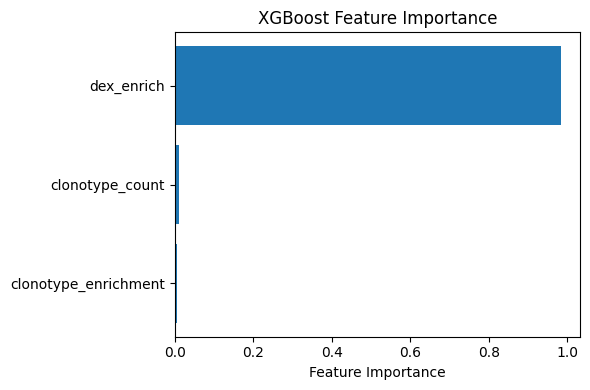

In [57]:
# Get importance scores
importance = xgb_model.feature_importances_
features = xgb_model.get_booster().feature_names

# Plot
plt.figure(figsize=(6, 4))
plt.barh(features, importance)
plt.xlabel("Feature Importance")
plt.title("XGBoost Feature Importance")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

Looking at just dex_norm ranks and not ML model rankings

In [47]:
# Group by (dextramer, clonotype) and calculate summary stats
dexnorm_ranks = X.groupby(["dextramer", "raw_clonotype_id"]).agg(
    mean_dex_norm=("dex_norm", "mean"),
    max_dex_norm=("dex_norm", "max"),
    count=("dex_norm", "count")
).reset_index()

# Filter to only pairs supported by > 5 cells
dexnorm_ranks = dexnorm_ranks[dexnorm_ranks["count"] > 5]

# Sort by mean dex_norm
dexnorm_ranks = dexnorm_ranks.sort_values(by="mean_dex_norm", ascending=False)

# Show top candidates
print("🔝 Top predicted binders based on raw dex_norm (count > 5):")
print(dexnorm_ranks.head(20))



🔝 Top predicted binders based on raw dex_norm (count > 5):
      dextramer raw_clonotype_id  mean_dex_norm  max_dex_norm  count
29228  SRSF2_31      clonotype16       3.423693      4.680203     57
38574   SRSF2_4      clonotype17       2.134104      4.041541     51
16431   SRSF2_2      clonotype83       2.110217      8.680152      6
49678   SRSF2_8     clonotype130       1.517130      2.587329      6
21607  SRSF2_24      clonotype94       1.465857      2.025000      7
16633  SRSF2_20     clonotype123       1.418425      2.403254      6
30036  SRSF2_32     clonotype123       1.413090      3.540622      6
12538  SRSF2_17     clonotype127       1.371400      1.901127      6
7128   SRSF2_11      clonotype80       1.280295      2.645963      9
47563   SRSF2_5     clonotype123       1.234002      3.104449      6
31901  SRSF2_33      clonotype88       1.231011      1.985968      9
31788  SRSF2_33      clonotype69       1.222868      3.135553     10
21849  SRSF2_25     clonotype131       1.219